In [1]:
#%pip install -r requirements.txt

#%pip freeze > requirements.txt # save installed un req

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
#from skimpy import skim

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
# для нейронки
from sklearn.preprocessing import LabelEncoder
# #from tensorflow.keras import Sequential
# import keras
# #from tensorflow.keras import layers, callbacks
# # from tensorflow.keras import Sequential
# # from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# # from tensorflow.keras.optimizers import Adam
# #from keras.metrics import BinaryAccuracy, AUC

# from keras.models import Sequential
# #from tensorflow import keras
# from keras.layers import Dense, SimpleRNN, Activation, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, Dropout
# from keras import optimizers
# from keras.utils import to_categorical



In [76]:
req = {"orderId": "unique_order_id",
 "items": [
    {"sku": "unique_sku_1", "count": 1, "a": 5.1, "b": 5.2, "c": 5.3,
     "weight": 7.34, "type": [2]},
    {"sku": "unique_sku_2", "count": 3, "a": 4, "b": 5.23, "c": 6.2,
     "weight": 7.45, "type": [8, 9, 10]},
    {"sku": "unique_sku_3", "count": 2, "a": 11, "b": 12.5, "c": 13.3,
     "weight": 14.2, "type": [15, 16]}
   ]
}

In [107]:
def req_to_df(req):
    df_req = pd.json_normalize(req, record_path=['items'], meta=['orderId'])
    df_req = df_req.astype(float, errors='ignore')

    # создаем пустой датафрейм, в который будем добавлять дубликаты строк
    new_df_req = pd.DataFrame()

    # итерируемся по строкам исходного датасета
    for _, row in df_req.iterrows():
        # получаем значение столбца "count"
        count = int(row['count'])
        # дублируем строку столько раз, сколько указано в столбце "count"
        for i in range(count):
            new_df_req = new_df_req.append(row, ignore_index=True)

    def gen_geometry_feat(df, a, b, c):
        '''
        генерим геометрические фичи
        a, b, c -- размеры
        '''
        #df[a, b, c] = df[a, b, c].astype(float)
        df['dim_sum'] = df[[a, b, c]].sum(axis=1)
        df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
        df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
        df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

        df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
        df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
        df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
        
        df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
        df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

        df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)

        df = df.rename(columns={
            'weight':'goods_wght',
            'vol':'sku_vol',
            'a':'sku_a',
            'b': 'sku_b',
            'c': 'sku_c'})
        return df


    df_req_geo = gen_geometry_feat(new_df_req, 'a', 'b', 'c')
    df_req_geo = df_req_geo.drop(['sku', 'type', 'orderId', 'count'], axis=1).sum()

    return pd.DataFrame(df_req_geo).T


In [108]:
req_to_df(req)

,sku_a,sku_b,sku_c,goods_wght,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,39.1,45.89,50.5,58.09,135.49,4183.0,44.0,44.0,360.0,391.0,455.0,360.0,399.0,78.6


In [65]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    #df[a, b, c] = df[a, b, c].astype(float)
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)

    df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})
    return df

In [74]:
pd.DataFrame(df_req_geo.sum()).T

,count,a,b,c,weight,dim_sum,vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,14.0,39.1,45.89,50.5,58.09,135.49,4183.0,44.0,44.0,360.0,391.0,455.0,360.0,399.0,78.6


In [ ]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

In [ ]:
df_sum = df.drop(['selected_carton', 'sku'], axis=1).groupby('orderkey', sort=False).sum() # суммируем по заказам

In [ ]:
# добавляем максимальные размеры одного товара
df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# ratio max к остальным
df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# weight
df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
df_grouped['sku_max_diag'] = round(np.sqrt(df['sku_a']**2 + df['sku_b']**2 + df['sku_c']**2), 1)

df_sum = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 
                                  'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 
                                  'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']], on='orderkey', how='left')

In [ ]:
import matplotlib as mlp

sns.set_theme(style='darkgrid', palette='mako')

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 15

In [ ]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [ ]:
RANDOM = 42

# LOADING DATA

In [103]:
cargotype_info = pd.read_csv('data/cargotype_info.csv', index_col='Unnamed: 0')
carton_price = pd.read_excel('data/carton_price.xlsx')
carton = pd.read_csv('data/carton.csv')
data = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
sku_cargotypes = pd.read_csv('data/sku_cargotypes.csv', index_col='Unnamed: 0')
sku = pd.read_csv('data/sku.csv', index_col='Unnamed: 0')

FileNotFoundError: [Errno 2] No such file or directory: 'data/cargotype_info.csv'

In [77]:
sku_cargotypes['cargotype'].value_counts()[((sku_cargotypes['cargotype'].value_counts() < 524000) & (sku_cargotypes['cargotype'].value_counts() > 21000))].sort_index().index

Index([ 120,  160,  292,  300,  301,  305,  320,  340,  350,  360,  400,  460,
        480,  485,  490,  520,  601,  610,  611,  620,  621,  622,  623,  640,
        641,  670,  671,  672,  673,  690,  691,  692,  720,  750,  770,  780,
        801,  901,  910,  920,  955,  960,  980, 1010],
      dtype='int64', name='cargotype')

In [78]:
def add_cargotype_row(data, sku_cargotypes, cargotype_num):
    data = data.drop(['cargotype'], errors='ignore', axis=1)
    data = data.merge(sku_cargotypes.query('cargotype == @cargotype_num'), on='sku', how='left')
    data = data.fillna(1)
    data['cargotype_'+ str(cargotype_num)] = data['cargotype']

    return data

In [79]:
for i in sku_cargotypes['cargotype'].value_counts().sort_index().index[:2]:
    print(i)
    data = add_cargotype_row(data, sku_cargotypes, i)

0
10


In [13]:
# явно отсортированные
not_need_box = [360, 340]

In [14]:
mb_not_important = [690, 691, 692, 931, 930, 350, 920, 292, 291, 290, 303, 302, 110, 752, 751, 410, 799, 20, 400, 0, 780, 760, 510, 150, 790, 950, 990, 985, 301]

carton_price.columns = ['cartontype', 'price']
carton.columns = [s.lower() for s in carton.columns]

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [16]:
corr_test = pd.merge(sku_cargotypes, data[['sku', 'selected_cartontype']], on='sku', how='left')

In [17]:
corr_test['selected_cartontype'] = label_encoder.fit_transform(corr_test['selected_cartontype'])

In [18]:
corr_test[['cargotype', 'selected_cartontype']].corr() # корреляция категория тип упаковки

,cargotype,selected_cartontype
cargotype,1.000000,0.021945
selected_cartontype,0.021945,1.000000


In [19]:
sku_cargotypes_filtred = pd.merge(data[['sku']].drop_duplicates(), sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
#sku_cargotypes_filtred = sku_cargotypes_filtred.query('cargotype not in @mb_not_important') # дропаем как мне кажется не особо важные
sku_groups = sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
#sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left') # 
sku_groups.head()

,sku,cargotype
0,00001dba9dfe01a550c23064c2b8e96f,[nan]
1,000198cfae123aef536f2fcf0b104049,"[290.0, 310.0, 410.0, 720.0, 750.0, 770.0]"
2,0003da69535758c817b78b64da05aae0,"[290.0, 310.0, 340.0, 750.0]"
3,0003fb4df9f32661d8772b1eac96e5ea,"[290.0, 600.0, 610.0, 950.0, 960.0, 970.0, 980.0]"
4,0005b21e4cba70e646f9f8f9a5d88d4e,"[290.0, 440.0, 441.0, 480.0, 490.0, 520.0, 690.0]"


In [20]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)
    return df

In [21]:
sku = gen_geometry_feat(sku, 'a', 'b', 'c')
carton = gen_geometry_feat(carton, 'length', 'width', 'height')

In [22]:
non_volume = ['KSD', 'NONPACK', 'STRETCH'] # нулевой объем помешает потом

In [23]:
# фичи для упаковок, для сравнения с фичами заказа
new_carton = carton.query('cartontype not in @non_volume').set_index('cartontype').unstack().reset_index()
new_carton = new_carton.rename(
    columns={
        'level_0': 'carton_dim',
        0: 'value'
})

new_carton['carton_type_dim'] = new_carton['carton_dim'] + '_' + new_carton['cartontype']
new_carton = new_carton.drop(['carton_dim', 'cartontype'], axis=1)
new_carton_t =  new_carton.set_index('carton_type_dim').T

In [24]:
df = data.copy()

In [25]:
cols_to_drop = ['who', # Лишняя информация
                'trackingid', # Лишняя информация для обучения
                'recommended_cartontype', # Работа прошлого алгоритма - для обучения лишняя инфа
                'recommended_carton', # Дубликат
                'selected_cartontype', # Дубликат 
                'rec_calc_cube', # Результат предсказания
                #'orderkey', 
                'whs' # Не влияет на задачу
                ]

In [26]:
df = df.drop(cols_to_drop, axis=1)
df.head()

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,cargotype,cargotype_0
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0


In [27]:
# не хватает оперативки

# mlb = MultiLabelBinarizer()
# one_hot = mlb.fit_transform(sku_groups['cargotype'])

# one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
# one_hot_df['sku'] = sku_groups['sku']
# df = pd.merge(df, one_hot_df, on='sku', how='left')

In [28]:
sku = sku[sku['vol']>0]

In [29]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,cargotype,cargotype_0,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4


In [30]:
df.isna().sum()

orderkey               0
box_num                0
selected_carton        0
sel_calc_cube          0
pack_volume            0
goods_wght             0
sku                    0
cargotype              0
cargotype_0            0
sku_a              10899
sku_b              10899
sku_c              10899
dim_sum            10899
sku_vol            10899
dim_mean           10899
dim_median         10899
prod_a_b           10899
prod_a_c           10899
prod_b_c           10899
prod_min           10899
prod_mean          10899
diag               10899
dtype: int64

In [31]:
df = df.dropna()
#df = df.query('goods_wght!=0') # metrics 0.3

In [33]:
df_sum = df.drop(['selected_carton', 'sku'], axis=1).groupby('orderkey', sort=False).sum() # суммируем по заказам

In [35]:
# возвращаем потеряный таргет
order_pack = df[['orderkey', 'selected_carton']].drop_duplicates()
df_sum = pd.merge(df_sum, order_pack, on= 'orderkey', how='left')

In [36]:
# добавляем максимальные размеры одного товара
df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# ratio max к остальным
df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# weight
df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
df_grouped['sku_max_diag'] = round(np.sqrt(df['sku_a']**2 + df['sku_b']**2 + df['sku_c']**2), 1)

df_sum = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 
                                  'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 
                                  'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']], on='orderkey', how='left')

In [37]:
df_sum

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,cargotype,cargotype_0,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,41.0,41.0,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,1.0,1.0,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,1.0,1.0,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,1.0,1.0,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,1.0,1.0,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155344,8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,2.0,2.0,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2,NONPACK,101.0,33.666667,25168.000,1.0,3.4,1.0,0.5,28.6,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,2.0,2.0,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,1.0,1.0,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,23.6
155347,2e2a642f611b5a6f2c404ab945fbc2a3,1,2816,552,0.230,1.0,1.0,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0,MYB,37.0,12.333333,552.000,1.0,11.5,1.9,4.2,10.0,23.5


In [38]:
new_carton_t

carton_type_dim,length_YMA,length_YMC,length_YME,length_YMF,length_YMG,length_YMH,length_YMJ,length_YML,length_YMN,length_YMO,length_YMP,length_YMQ,length_YMR,length_YMS,length_YMU,length_YMV,length_YMW,length_YMХ,length_MYF,length_YMX,length_YMY,length_MYA,length_MYB,length_MYC,length_MYD,length_MYE,width_YMA,width_YMC,width_YME,width_YMF,width_YMG,width_YMH,width_YMJ,width_YML,width_YMN,width_YMO,width_YMP,width_YMQ,width_YMR,width_YMS,width_YMU,width_YMV,width_YMW,width_YMХ,width_MYF,width_YMX,width_YMY,width_MYA,width_MYB,width_MYC,width_MYD,width_MYE,height_YMA,height_YMC,height_YME,height_YMF,height_YMG,height_YMH,height_YMJ,height_YML,height_YMN,height_YMO,height_YMP,height_YMQ,height_YMR,height_YMS,height_YMU,height_YMV,height_YMW,height_YMХ,height_MYF,height_YMX,height_YMY,height_MYA,height_MYB,height_MYC,height_MYD,height_MYE,displayrfpack_YMA,displayrfpack_YMC,displayrfpack_YME,displayrfpack_YMF,displayrfpack_YMG,displayrfpack_YMH,displayrfpack_YMJ,displayrfpack_YML,displayrfpack_YMN,displayrfpack_YMO,displayrfpack_YMP,displayrfpack_YMQ,displayrfpack_YMR,displayrfpack_YMS,displayrfpack_YMU,displayrfpack_YMV,displayrfpack_YMW,displayrfpack_YMХ,displayrfpack_MYF,displayrfpack_YMX,displayrfpack_YMY,displayrfpack_MYA,displayrfpack_MYB,displayrfpack_MYC,displayrfpack_MYD,displayrfpack_MYE,dim_sum_YMA,dim_sum_YMC,dim_sum_YME,dim_sum_YMF,dim_sum_YMG,dim_sum_YMH,dim_sum_YMJ,dim_sum_YML,dim_sum_YMN,dim_sum_YMO,dim_sum_YMP,dim_sum_YMQ,dim_sum_YMR,dim_sum_YMS,dim_sum_YMU,dim_sum_YMV,dim_sum_YMW,dim_sum_YMХ,dim_sum_MYF,dim_sum_YMX,dim_sum_YMY,dim_sum_MYA,dim_sum_MYB,dim_sum_MYC,dim_sum_MYD,dim_sum_MYE,vol_YMA,vol_YMC,vol_YME,vol_YMF,vol_YMG,vol_YMH,vol_YMJ,vol_YML,vol_YMN,vol_YMO,vol_YMP,vol_YMQ,vol_YMR,vol_YMS,vol_YMU,vol_YMV,vol_YMW,vol_YMХ,vol_MYF,vol_YMX,vol_YMY,vol_MYA,vol_MYB,vol_MYC,vol_MYD,vol_MYE,dim_mean_YMA,dim_mean_YMC,dim_mean_YME,dim_mean_YMF,dim_mean_YMG,dim_mean_YMH,dim_mean_YMJ,dim_mean_YML,dim_mean_YMN,dim_mean_YMO,dim_mean_YMP,dim_mean_YMQ,dim_mean_YMR,dim_mean_YMS,dim_mean_YMU,dim_mean_YMV,dim_mean_YMW,dim_mean_YMХ,dim_mean_MYF,dim_mean_YMX,dim_mean_YMY,dim_mean_MYA,dim_mean_MYB,dim_mean_MYC,dim_mean_MYD,dim_mean_MYE,dim_median_YMA,dim_median_YMC,dim_median_YME,dim_median_YMF,dim_median_YMG,dim_median_YMH,dim_median_YMJ,dim_median_YML,dim_median_YMN,dim_median_YMO,dim_median_YMP,dim_median_YMQ,dim_median_YMR,dim_median_YMS,dim_median_YMU,dim_median_YMV,dim_median_YMW,dim_median_YMХ,dim_median_MYF,dim_median_YMX,dim_median_YMY,dim_median_MYA,dim_median_MYB,dim_median_MYC,dim_median_MYD,dim_median_MYE,prod_a_b_YMA,prod_a_b_YMC,prod_a_b_YME,prod_a_b_YMF,prod_a_b_YMG,prod_a_b_YMH,prod_a_b_YMJ,prod_a_b_YML,prod_a_b_YMN,prod_a_b_YMO,prod_a_b_YMP,prod_a_b_YMQ,prod_a_b_YMR,prod_a_b_YMS,prod_a_b_YMU,prod_a_b_YMV,prod_a_b_YMW,prod_a_b_YMХ,prod_a_b_MYF,prod_a_b_YMX,prod_a_b_YMY,prod_a_b_MYA,prod_a_b_MYB,prod_a_b_MYC,prod_a_b_MYD,prod_a_b_MYE,prod_a_c_YMA,prod_a_c_YMC,prod_a_c_YME,prod_a_c_YMF,prod_a_c_YMG,prod_a_c_YMH,prod_a_c_YMJ,prod_a_c_YML,prod_a_c_YMN,prod_a_c_YMO,prod_a_c_YMP,prod_a_c_YMQ,prod_a_c_YMR,prod_a_c_YMS,prod_a_c_YMU,prod_a_c_YMV,prod_a_c_YMW,prod_a_c_YMХ,prod_a_c_MYF,prod_a_c_YMX,prod_a_c_YMY,prod_a_c_MYA,prod_a_c_MYB,prod_a_c_MYC,prod_a_c_MYD,prod_a_c_MYE,prod_b_c_YMA,prod_b_c_YMC,prod_b_c_YME,prod_b_c_YMF,prod_b_c_YMG,prod_b_c_YMH,prod_b_c_YMJ,prod_b_c_YML,prod_b_c_YMN,prod_b_c_YMO,prod_b_c_YMP,prod_b_c_YMQ,prod_b_c_YMR,prod_b_c_YMS,prod_b_c_YMU,prod_b_c_YMV,prod_b_c_YMW,prod_b_c_YMХ,prod_b_c_MYF,prod_b_c_YMX,prod_b_c_YMY,prod_b_c_MYA,prod_b_c_MYB,prod_b_c_MYC,prod_b_c_MYD,prod_b_c_MYE,prod_min_YMA,prod_min_YMC,prod_min_YME,prod_min_YMF,prod_min_YMG,prod_min_YMH,prod_min_YMJ,prod_min_YML,prod_min_YMN,prod_min_YMO,prod_min_YMP,prod_min_YMQ,prod_min_YMR,prod_min_YMS,prod_min_YMU,prod_min_YMV,prod_min_YMW,prod_min_YMХ,prod_min_MYF,prod_min_YMX,prod_min_YMY,prod_min_MYA,prod_min_MYB,prod_min_MYC,prod_min_MYD,prod_min_MYE,prod_mean_YMA,prod_mean_YMC,prod_mean_YME,prod_mean_YMF,prod_mean_YMG,prod_mean_YMH,

In [39]:
# df = df_sum.dropna().reset_index(drop=True)
#df = df[df['selected_carton']!='YMB']
# df[df['selected_carton'] =='YMB']

In [40]:
# создаем столбцы с размерами коробок пока объем и диагонали(feature_importance считает что они важны)
# df_sum[new_carton_t.filter(like='vol').columns.tolist()] = new_carton_t[new_carton_t.filter(like='vol').columns.tolist()].values.reshape(-1,1).flatten().tolist()
# df_sum[new_carton_t.filter(like='diag').columns.tolist()] = new_carton_t[new_carton_t.filter(like='diag').columns.tolist()].values.reshape(-1,1).flatten().tolist()
# df_sum[new_carton_t.filter(like='length').columns.tolist()] = new_carton_t[new_carton_t.filter(like='length').columns.tolist()].values.reshape(-1,1).flatten().tolist()

In [41]:
df_sum.head(3)

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,cargotype,cargotype_0,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,41.0,41.0,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,1.0,1.0,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,1.0,1.0,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4


In [42]:
df = df.drop('orderkey', axis=1)

In [43]:
df

,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,cargotype,cargotype_0,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
3,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
4,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,1.0,1.0,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,1.0,1.0,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325619,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,1.0,1.0,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325620,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,1.0,1.0,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9
325621,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,1.0,1.0,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0


<Axes: >

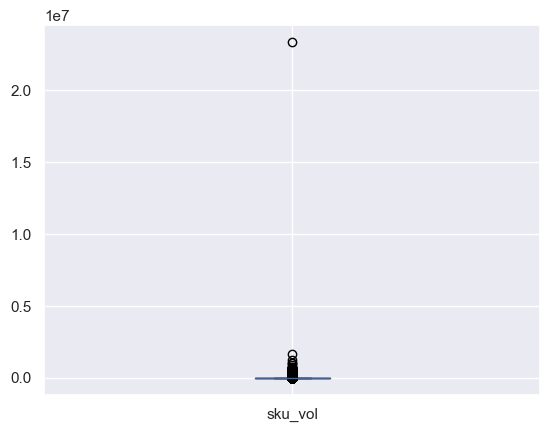

In [44]:
df_sum['sku_vol'].plot(kind='box')

In [45]:
# дроп выбросов по объему
q1 = df_sum['sku_vol'].quantile(0.25)
q3 = df_sum['sku_vol'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outlier_vol = df_sum[(df_sum['sku_vol'] >= lower_bound) & (df_sum['sku_vol'] <= upper_bound)]

<Axes: >

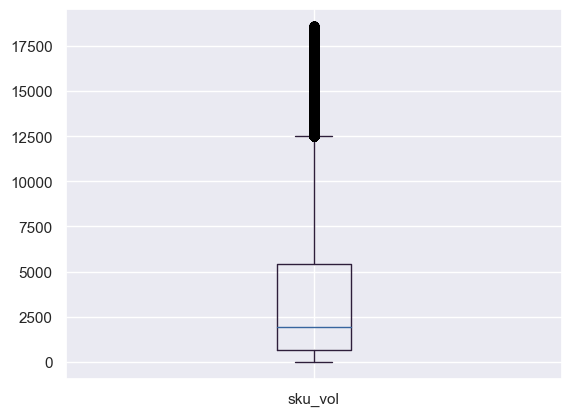

In [46]:
df_no_outlier_vol['sku_vol'].plot(kind='box')

In [47]:
# для категорий товаров
# df.describe()
# cols_zero_max = df.describe().columns[df.describe().loc['max'] == 0]
# cols_zero_max
# df = df.drop(cols_zero_max, axis=1)

In [48]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,cargotype,cargotype_0,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,1.0,1.0,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,1.0,1.0,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,1.0,1.0,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,1.0,1.0,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,1.0,1.0,29.0,9.0,29.0,67.0,7569.0,22.0,29.0,261.0,841.0,261.0,261.0,454.0,42.0,NONPACK,67.0,22.333333,7569.000,1.0,3.2,1.0,8.0,209.7,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155342,3acc4b901256bcd9f333b6978864773b,1,8525,4050,1.740,1.0,1.0,25.0,9.0,18.0,52.0,4050.0,17.0,18.0,225.0,450.0,162.0,162.0,279.0,32.1,YMC,52.0,17.333333,4050.000,1.0,2.8,1.4,4.3,69.6,24.6
155343,b2d5108421ce9c823a083fdaf870b9a2,6,130872,12510,1.236,6.0,6.0,251.4,12.6,142.2,406.2,12510.0,132.0,138.0,522.0,5958.0,294.0,294.0,2256.0,289.2,YMW,67.7,22.566667,2085.363,1.0,20.0,1.8,1.0,4.9,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,2.0,2.0,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,1.0,1.0,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,23.6


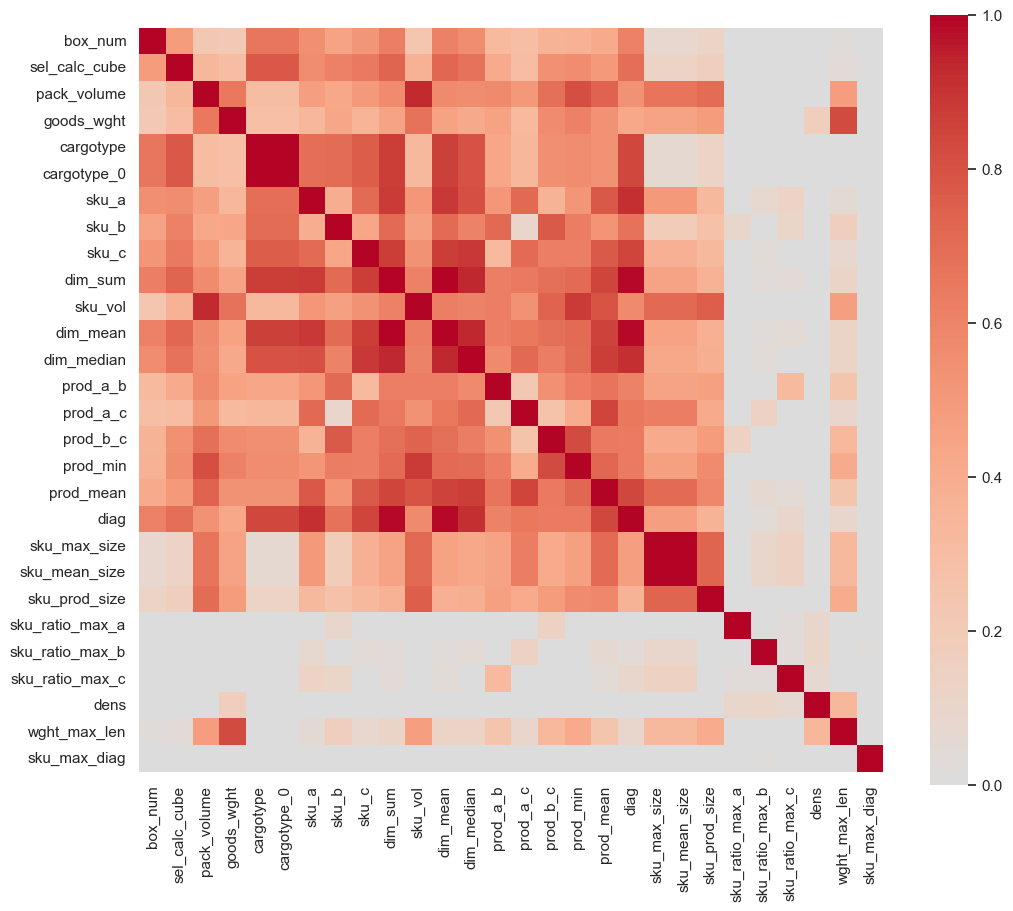

In [49]:
numeric_columns = df_no_outlier_vol.loc[:,df_no_outlier_vol.dtypes!=np.object_].columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outlier_vol[numeric_columns].corr(), 
            #annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

In [50]:
corr_feat = set()
corr_matrix = df_no_outlier_vol[numeric_columns].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

{'cargotype_0',
 'diag',
 'dim_mean',
 'dim_median',
 'dim_sum',
 'prod_mean',
 'prod_min',
 'sku_mean_size',
 'sku_vol'}

In [51]:
# Проверить
df_no_outlier_vol = df_no_outlier_vol.drop(corr_feat, axis=1)

In [52]:
# fltr_nonpack =  ["STRETCH", "NONPACK"] # 
# df_no_outlier_vol = df_no_outlier_vol.query('selected_carton not in @fltr_nonpack')
# df_no_outlier_vol

# Модель 1

In [53]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,cargotype,sku_a,sku_b,sku_c,prod_a_b,prod_a_c,prod_b_c,selected_carton,sku_max_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,1.0,18.6,3.3,49.7,61.0,924.0,164.0,STRETCH,71.6,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,1.0,30.0,23.0,22.0,690.0,660.0,506.0,STRETCH,75.0,15180.000,1.0,1.3,1.4,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,1.0,14.0,10.7,43.8,149.0,613.0,468.0,STRETCH,68.5,6561.240,3.1,4.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,1.0,23.4,8.0,33.9,187.0,793.0,271.0,STRETCH,65.3,6346.080,1.4,4.2,1.0,3.3,61.3,33.4
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,1.0,29.0,9.0,29.0,261.0,841.0,261.0,NONPACK,67.0,7569.000,1.0,3.2,1.0,8.0,209.7,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155342,3acc4b901256bcd9f333b6978864773b,1,8525,4050,1.740,1.0,25.0,9.0,18.0,225.0,450.0,162.0,YMC,52.0,4050.000,1.0,2.8,1.4,4.3,69.6,24.6
155343,b2d5108421ce9c823a083fdaf870b9a2,6,130872,12510,1.236,6.0,251.4,12.6,142.2,522.0,5958.0,294.0,YMW,67.7,2085.363,1.0,20.0,1.8,1.0,4.9,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,2.0,52.0,40.0,8.0,1040.0,208.0,160.0,MYC,50.0,2080.000,1.0,1.3,6.5,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,1.0,11.4,10.2,30.3,116.0,345.0,309.0,YMC,51.9,3523.284,2.7,3.0,1.0,0.8,9.4,23.6


In [54]:
df_no_outlier_vol = df_no_outlier_vol.query('selected_carton != "YMB"') # один случай дропаем из-за stratify

In [55]:
df_no_outlier_vol = df_no_outlier_vol.dropna()

In [56]:
df_no_outlier_vol['selected_carton'].value_counts()

selected_carton
MYB        39498
MYC        29024
MYA        14358
MYD        12772
YMC         7916
NONPACK     7823
YMA         6729
STRETCH     5321
YMF         4036
MYE         3959
YMW         3407
YMG         2560
MYF          789
YME          322
YMX           29
YML            7
Name: count, dtype: int64

In [57]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']

In [58]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol['selected_carton']
                                                    )

In [59]:
# X_train.to_csv('X_train.csv')
# X_test.to_csv('X_test.csv')
# y_train.to_csv('y_train.csv')
# y_test.to_csv('y_test.csv')


In [60]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [61]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=6)),
    #('kmeans', KMeans(n_clusters=5)),
    #('nb', MLPClassifier(verbose=True)),


    
    ('tree', CatBoostClassifier(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        iterations=500,
        #subsample=0.1,
        #max_depth=5,
        verbose=10,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        #eval_metric='TotalF1'
        ))
])

tree_pipe.fit(X_train, y_train)

Learning rate set to 0.180112
0:	learn: 2.2275017	total: 399ms	remaining: 3m 19s
10:	learn: 1.5815694	total: 2.73s	remaining: 2m 1s
20:	learn: 1.5062597	total: 5.08s	remaining: 1m 55s
30:	learn: 1.4824191	total: 7.49s	remaining: 1m 53s
40:	learn: 1.4676250	total: 9.82s	remaining: 1m 49s
50:	learn: 1.4553311	total: 12.2s	remaining: 1m 47s
60:	learn: 1.4451016	total: 14.5s	remaining: 1m 44s
70:	learn: 1.4379617	total: 17s	remaining: 1m 42s
80:	learn: 1.4303781	total: 20.2s	remaining: 1m 44s
90:	learn: 1.4240926	total: 22.7s	remaining: 1m 42s
100:	learn: 1.4171508	total: 25.3s	remaining: 1m 39s
110:	learn: 1.4108344	total: 27.9s	remaining: 1m 37s
120:	learn: 1.4055848	total: 30.5s	remaining: 1m 35s
130:	learn: 1.3992999	total: 33s	remaining: 1m 32s
140:	learn: 1.3945211	total: 35.6s	remaining: 1m 30s
150:	learn: 1.3898416	total: 38.2s	remaining: 1m 28s
160:	learn: 1.3858941	total: 40.7s	remaining: 1m 25s
170:	learn: 1.3809278	total: 43.5s	remaining: 1m 23s
180:	learn: 1.3766748	total: 46.

Pipeline(steps=[('tree',
                 <catboost.core.CatBoostClassifier object at 0x000002E6AF72F220>)])

Text(0.5, 1.0, 'Feature Importance')

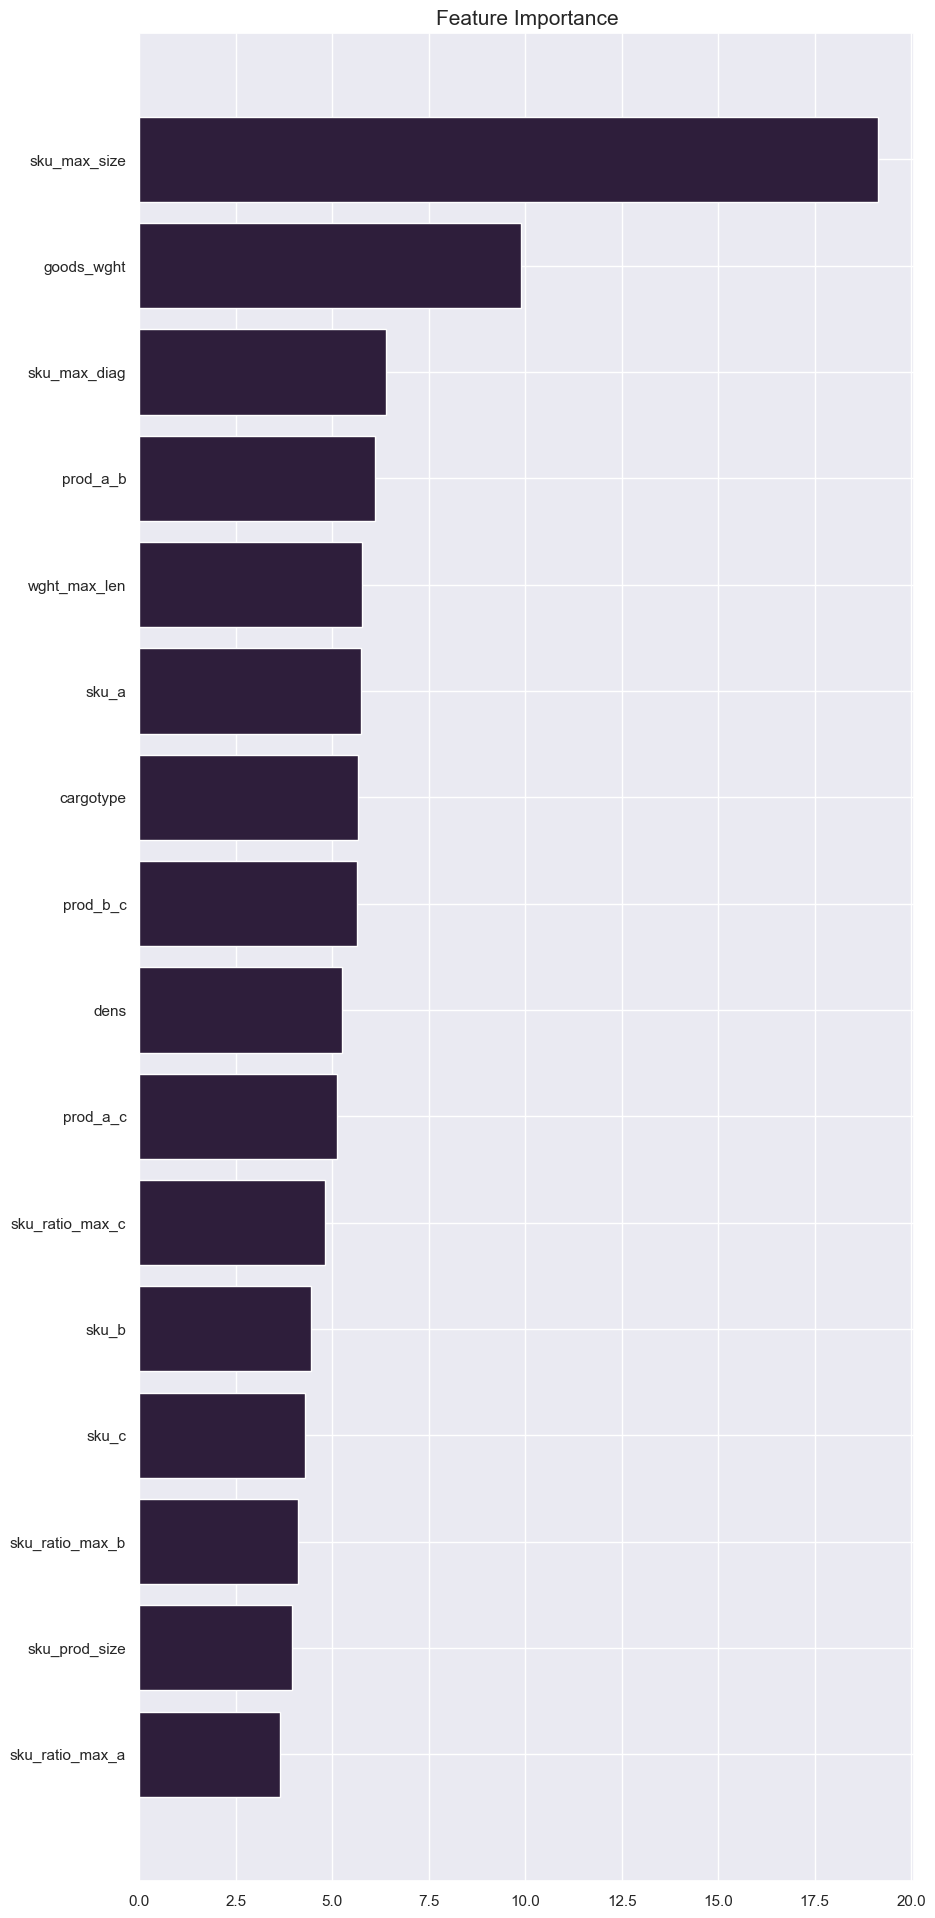

In [62]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [63]:
tree_preds = tree_pipe.predict(X_test)
tree_pred_proba = tree_pipe.predict_proba(X_test)

print(f'TRAIN ACC: {accuracy_score(y_train, tree_pipe.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')
print(f'TEST F1: {f1_score(y_test, tree_preds, average="weighted")}')

print(classification_report(y_test, tree_preds))

TRAIN ACC: 0.5415447686503965
TEST ACC: 0.49076159131589586
TEST F1: 0.4772567250384389
              precision    recall  f1-score   support

         MYA       0.57      0.44      0.50      3590
         MYB       0.60      0.70      0.64      9875
         MYC       0.49      0.55      0.52      7256
         MYD       0.37      0.45      0.41      3193
         MYE       0.23      0.12      0.16       990
         MYF       0.00      0.00      0.00       197
     NONPACK       0.51      0.55      0.53      1956
     STRETCH       0.35      0.21      0.26      1330
         YMA       0.44      0.17      0.25      1682
         YMC       0.36      0.35      0.35      1979
         YME       0.50      0.03      0.05        80
         YMF       0.26      0.22      0.24      1009
         YMG       0.35      0.31      0.33       640
         YML       0.00      0.00      0.00         2
         YMW       0.28      0.29      0.28       852
         YMX       0.00      0.00      0.00    

In [64]:
y_proba = tree_pipe.predict_proba(X_test[100:110])

# два наиболее вероятных класса с вероятностями
top_two = y_proba.argsort()[:, -2:]
top_two_proba = np.round(np.sort(y_proba, axis=1)[:, -2:], 2)

# результаты предсказания
for i in range(len(X_test[100:110])):
    class_names = tree_pipe.classes_[top_two[i]]
    print(f"Для заказа № {i} рекомендуется упаковка: {class_names[0]}, {top_two_proba[i][0]*100}% или {class_names[1]}, {top_two_proba[i][1]*100}%, тест {y_test.iloc[i]}")

Для заказа № 0 рекомендуется упаковка: YMG, 19.0% или YMW, 53.0%, тест STRETCH
Для заказа № 1 рекомендуется упаковка: MYB, 39.0% или MYC, 50.0%, тест MYC
Для заказа № 2 рекомендуется упаковка: STRETCH, 36.0% или NONPACK, 63.0%, тест YMF
Для заказа № 3 рекомендуется упаковка: MYC, 23.0% или YMA, 53.0%, тест STRETCH
Для заказа № 4 рекомендуется упаковка: MYC, 10.0% или MYB, 73.0%, тест MYB
Для заказа № 5 рекомендуется упаковка: MYB, 40.0% или MYA, 54.0%, тест MYB
Для заказа № 6 рекомендуется упаковка: MYC, 37.0% или MYB, 51.0%, тест MYC
Для заказа № 7 рекомендуется упаковка: MYC, 9.0% или YMC, 62.0%, тест MYC
Для заказа № 8 рекомендуется упаковка: MYA, 31.0% или MYB, 55.00000000000001%, тест YMF
Для заказа № 9 рекомендуется упаковка: YMF, 17.0% или YMW, 17.0%, тест YMA


# Модель 2

In [65]:
# расчет по объему поэтому 0 отбрасываем
zero_vol = ['KSD', 'NONPACK', 'STRETCH']

In [66]:
carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}).sort_values('vol')

,selected_carton,vol
24,MYA,999.0
21,MYF,1500.0
17,YMU,2592.0
25,MYB,3449.0
0,YMA,3705.0
18,YMV,4292.0
26,MYC,8436.0
1,YMC,9000.0
3,YMF,13125.0
27,MYD,15579.0


In [67]:
df_no_outlier_vol_regr = pd.merge(df_no_outlier_vol, 
         carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}), 
         on='selected_carton', 
         how='left')

df_no_outlier_vol_regr = df_no_outlier_vol_regr.dropna()

In [68]:
X = df_no_outlier_vol_regr.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey', 'vol'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol_regr['vol']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol_regr['vol']
                                                    )

In [69]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=6)),
    #('kmeans', KMeans(n_clusters=5)),
    #('nb', MLPClassifier(verbose=True)),


    
    ('tree', CatBoostRegressor(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        #iterations=1000,
        #subsample=0.1,
        #max_depth=4,
        verbose=100,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        #loss_function='MultiClass',
        #eval_metric='TotalF1',
        eval_metric="RMSE"
        ))
])

tree_pipe.fit(X_train, y_train)

Learning rate set to 0.083941
0:	learn: 6397.7521226	total: 19.1ms	remaining: 19.1s
100:	learn: 4530.5755854	total: 1.89s	remaining: 16.9s
200:	learn: 4439.0822525	total: 3.27s	remaining: 13s
300:	learn: 4368.0997434	total: 4.75s	remaining: 11s
400:	learn: 4314.8933100	total: 6.17s	remaining: 9.21s
500:	learn: 4270.5995360	total: 7.54s	remaining: 7.51s
600:	learn: 4229.8071663	total: 8.82s	remaining: 5.85s
700:	learn: 4193.1044974	total: 10.3s	remaining: 4.4s
800:	learn: 4159.4905290	total: 12.3s	remaining: 3.06s


KeyboardInterrupt: 

In [ ]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
cartontype_sorted_vol = carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}).sort_values('vol')

In [ ]:
y_proba = tree_pipe.predict(X_test[100:110])

In [ ]:
threshold = y_proba[0]
cartontype_sorted_vol['diff'] = np.abs(cartontype_sorted_vol['vol'] - threshold)
cartontype_sorted_vol = cartontype_sorted_vol.sort_values('diff')

# получение первых двух строк с diff > 0
result = cartontype_sorted_vol[cartontype_sorted_vol['diff'] > 0].head(2)['selected_carton'].values
print(result)

# Модель 3

In [ ]:
def base_line(order):
    '''
    Получаем order -- json запрос с перечнем товаров
    ищем минимально возможную упаковку из словаря boxes для всех товаров
    Возвращаем {"orderid": "sdfsdf", "package": "ADC", "status": "ok"}
    !!! нет проверок на типы
    !!! если есть товар который не влезет выдаст None, проверки по остальным не сделает
    '''

    def multiply_min(lst, number):
        '''
        типотеза что сложение предметов в пачку идет в первую очередь по меньшему размеру
        '''
        min_val = min(lst)
        min_index = lst.index(min_val)
        lst[min_index] *= number
        return lst

    orderId = order['orderId']
    bricks = [] # размеры товаров в список
    vol_range = {} # объемы для последующего отсева наиболее объемных
    for i in order['items']:
        sizes = (float(i['size1']), float(i['size2']), float(i['size3']))
        sizes = multiply_min(list(sizes), i['count'])
        vol_range[i['sku']] = float(i['size1']) * float(i['size2']) * float(i['size3'])
        bricks.append(sizes)
        # for j in range(i['count']):
        #
    # размеры коробок
    boxes = {
        'KSD': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'STRETCH': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'NONPACK': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'MYA': {'x': 15.0, 'y': 20.0, 'z': 3.33},
        'MYF': {'x': 20.0, 'y': 15.0, 'z': 5.0},
        'YMU': {'x': 27.0, 'y': 24.0, 'z': 4.0},
        'MYB': {'x': 22.0, 'y': 32.0, 'z': 4.9},
        'YMA': {'x': 24.7, 'y': 15.0, 'z': 10.0},
        'YMV': {'x': 37.0, 'y': 29.0, 'z': 4.0},
        'MYC': {'x': 30.0, 'y': 38.0, 'z': 7.4},
        'YMC': {'x': 30.0, 'y': 20.0, 'z': 15.0},
        'YMF': {'x': 35.0, 'y': 25.0, 'z': 15.0},
        'MYD': {'x': 38.0, 'y': 50.0, 'z': 8.2},
        'YMW': {'x': 40.0, 'y': 30.0, 'z': 15.0},
        'MYE': {'x': 43.0, 'y': 63.0, 'z': 9.7},
        'YMG': {'x': 44.7, 'y': 30.0, 'z': 20.0},
        'YME': {'x': 30.0, 'y': 30.0, 'z': 44.5},
        'YMP': {'x': 70.0, 'y': 30.0, 'z': 22.0},
        'YMХ': {'x': 40.0, 'y': 18.0, 'z': 65.0},
        'YMO': {'x': 65.0, 'y': 45.0, 'z': 20.0},
        'YMJ': {'x': 50.0, 'y': 29.0, 'z': 48.0},
        'YMH': {'x': 42.0, 'y': 20.0, 'z': 86.0},
        'YMY': {'x': 52.0, 'y': 20.0, 'z': 70.0},
        'YML': {'x': 60.0, 'y': 40.0, 'z': 45.0},
        'YMN': {'x': 60.0, 'y': 60.0, 'z': 40.0},
        'YMQ': {'x': 70.0, 'y': 60.0, 'z': 40.0},
        'YMS': {'x': 89.5, 'y': 59.5, 'z': 49.5},
        'YMR': {'x': 80.0, 'y': 60.0, 'z': 80.0}
    }

    def is_fitting(box, bricks):
        for brick in bricks:
            if box['x'] < brick[0] or box['y'] < brick[1] or box['z'] < brick[2]:
                return False
            box = {
                'x': max(box['x'] - brick[0], 0),
                'y': max(box['y'] - brick[1], 0),
                'z': max(box['z'] - brick[2], 0)
            }
        return True

    def find_box(bricks, boxes):
        min_box = None
        min_vol = float('inf')
        for box_name, box in boxes.items():
            if is_fitting(box, bricks):
                vol = box['x'] * box['y'] * box['z']
                if vol < min_vol:
                    min_box = box_name
                    min_vol = vol
        return min_box

    def answer(orderId=orderId, min_box_name='None', status='ok'):
        answer = {}
        answer['orderid'] = orderId
        answer['package'] = min_box_name
        answer['status'] = 'ok'
        return answer

    if find_box(bricks, boxes) != 'None':
        return answer(min_box_name=find_box(bricks, boxes))
    else:
        return answer(min_box_name='STRETCH')

    #
    # while
    #     vol_range.pop(max(vol_range))

    # return min_box_name


order = {"orderId": "af49bf330e2cf16e44f0be1bdfe337bd",
 "items": [
    {"sku": "unique_sku_1", "count": 2,
     "size1": "12", "size2": "6", "size3": "3",
     "weight": "7.34", "type": ["2"]},
    {"sku": "unique_sku_2", "count": 3,
     "size1": "4", "size2": "5.23", "size3": "6.2",
     "weight": "7.45", "type": ["8", "9", "10"]},
    {"sku": "unique_sku_3", "count": 2,
     "size1": "11", "size2": "12.5", "size3": "13.3",
     "weight": "14.2", "type": ["15", "16"]}
   ]
}

print(base_line(order))